In [1]:
# Importing all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from mri.operators import NonCartesianFFT, WaveletN, WaveletUD2, FFT
from mri.operators.utils import normalize_frequency_locations
from mri.reconstructors import SingleChannelReconstructor
from mri.operators.fourier.utils import estimate_density_compensation
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold, GroupLASSO
from mri.operators import ORCFFTWrapper

/neurospin/optimed/KPooja/Environments/EPI_sparkling/lib/python3.8/site-packages/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "


In [3]:
#Parameters details
FOV = (0.2, 0.2)
img_size = (128, 128)
grad_max = 0.5*1e-3   
dwell_time=0.14
gamma=42.576e6
gradient_raster_time=0.14
num_samples_per_shot = 320
num_shots = 512
dimension = 2

In [4]:
# Extracting raw kspace data and locations
data = pd.read_csv('080623_RADSE_phantom_512traj_320pts_10acq_2pi_corr.dat', sep="\s+", header=None)
Kspace_real = data.iloc[:, 3]
Kspace_imag = data.iloc[:, 4]
kx = data.iloc[:, 0]
ky = data.iloc[:, 2]

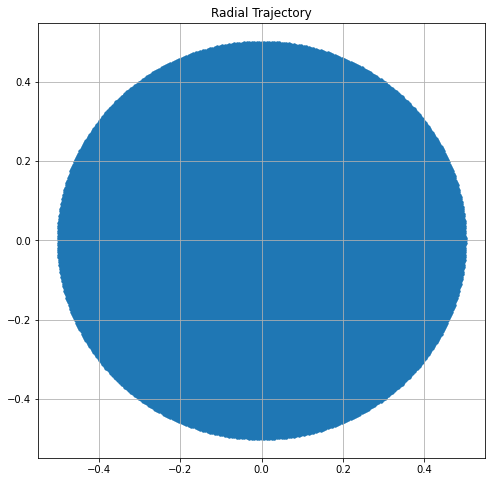

In [5]:
#Normalized kspace location
Kx = np.array(kx)
Ky = np.array(ky)

Kx = np.reshape(Kx, (num_shots, num_samples_per_shot))
Ky = np.reshape(Ky, (num_shots, num_samples_per_shot))

for i in range(num_shots):
    Kx[i, :] = Kx[i,:] - np.mean(Kx[i,:])
    Ky[i, :] = Ky[i,:] - np.mean(Ky[i,:])

Kx = np.reshape(Kx, (num_shots*num_samples_per_shot))
Ky = np.reshape(Ky, (num_shots*num_samples_per_shot))

kspace_loc1 = np.zeros((num_shots*num_samples_per_shot,dimension))
kspace_loc1[:,0] = Kx
kspace_loc1[:,1] = Ky

max_kx=np.max(kx)
max_ky=np.max(ky)
min_kx=np.min(kx)
min_ky=np.min(ky)

for i in range(num_shots*num_samples_per_shot):
   kspace_loc1[i,0] = (kspace_loc1[i,0]-min_kx)/(max_kx-min_kx)-0.5
   kspace_loc1[i,1] = (kspace_loc1[i,1]-min_ky)/(max_ky-min_ky)-0.5


kspace = plt.figure(figsize = (8,8))
#plot shots
plt.scatter(kspace_loc1[:,0],kspace_loc1[:,1], marker = '.')
plt.title("Radial Trajectory")
axes = plt.gca() 
plt.grid()

In [ ]:
# Generating Radial Trajectory 
rfactor = 2
img_size = 256
nb_shots = math.ceil(img_size/rfactor)
print("number of shots: {}".format(nb_shots))

# vectorize the nb of shots    
vec_shots = np.arange(0,nb_shots)

# define the regularly spaced samples on a single shot
nsamples = (np.arange(0,img_size) - img_size//2)
print("number of samples per shot: {}".format(np.size(nsamples)))

shot_c = np.array(nsamples, dtype = np.complex_)
shots = np.array([], dtype = np.complex_)    
# acculumate shots after rotating the initial one by the right angular increment        
for k in vec_shots:
    shots = np.append(shots, shot_c * np.exp(2 * np.pi * 1j * k/(2*nb_shots)))

kspace_loc = np.zeros((len(shots),2))
#assign real and imaginary parts of complex-valued k-space trajectories to k-space locations
kspace_loc[:,0] = shots.real
kspace_loc[:,1] = shots.imag

kspace = plt.figure(figsize = (8,8))
#plot shots
plt.scatter(kspace_loc[:,0],kspace_loc[:,1], marker = '.')
plt.title("Radial undersampling R = %d" %rfactor)

axes = plt.gca() 
plt.grid()

In [6]:
# Saving Trajectories
# np.savetxt('Radial_128shots_256samples_kspaceloc.txt', kspace_loc)

In [6]:
#arranging the kspace data in complex form
K_real = np.array(Kspace_real)
K_imag = np.array(Kspace_imag)
kspace_data = np.zeros((num_shots * num_samples_per_shot),dtype = np.complex_)
kspace_data.real = K_real
kspace_data.imag = K_imag

In [7]:
# Zerofilled Reconstruction

density_comp = estimate_density_compensation(kspace_loc1, img_size) 
fourier_op = NonCartesianFFT(samples=kspace_loc1,
                              shape= img_size,
                              implementation='gpuNUFFT',
                              density_comp = density_comp,
                              n_coils=1,)

img_recon = fourier_op.adj_op(kspace_data)

Text(0.5, 1.0, '2D VLFMRI Radial Zero Filling')

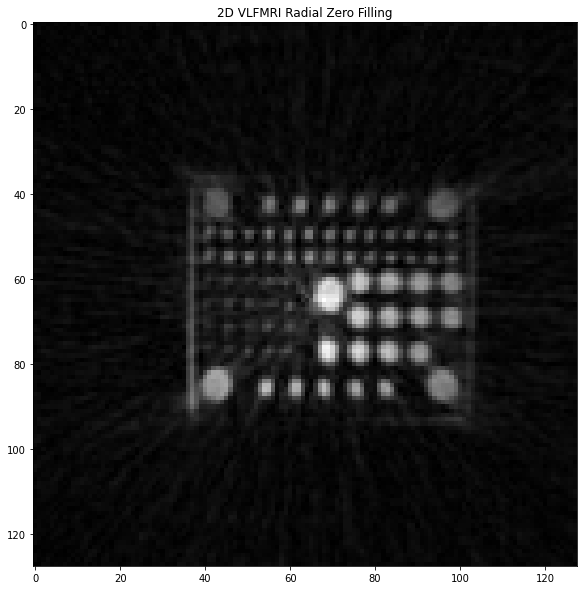

In [8]:
import matplotlib.pyplot as plt
from modopt.math.metrics import ssim, psnr
plt.figure(num=2, figsize = (10,10))
vol = img_recon
plt.imshow(abs(vol), cmap='gray')
plt.title("2D VLFMRI Radial Zero Filling")

In [71]:
# CS Reconstruction
def single_coil_recon(mu, dens_compense, kspace_data, kspace_loc, M, iter):
    if dens_compense == True:
        density_comp = estimate_density_compensation(kspace_loc, M)                              
        fourier_op = NonCartesianFFT(samples=kspace_loc,
                              shape= M,
                              implementation='gpuNUFFT',
                              density_comp = density_comp,
                              n_coils=1,)
    else:
        fourier_op = NonCartesianFFT(samples=kspace_loc,
                              shape= M,
                              implementation='gpuNUFFT',
                              n_coils=1,)
    
    regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")
    
    linear_op = WaveletN(wavelet_name='sym8',
                         nb_scale=4,
                         dim=2,
                         padding='periodization')
        
    reconstructor = SingleChannelReconstructor(
                        fourier_op=fourier_op,
                        linear_op=linear_op,
                        regularizer_op=regularizer_op,
                        gradient_formulation='synthesis'
                        )

    reconst_data, costs, metrics = reconstructor.reconstruct(kspace_data= kspace_data, optimization_alg = 'pogm', num_iterations = iter,)

    return(reconst_data, costs, metrics)

In [72]:
recont_data, costs, metric= single_coil_recon(0.01, True, kspace_data, kspace_loc, img_size, 500)

N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (4 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13
  1% (7 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13
  2% (11 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:13
  2% (13 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:13
  3% (17 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:13
  3% (19 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:13
  4% (23 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:13
  5% (26 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:12
  6% (30 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:12
  6% (32 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:12
  7% (36 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:12
  7% (38 of 500) |#                     

Text(0.5, 1.0, '2D VLFMRI Radial (CS)')

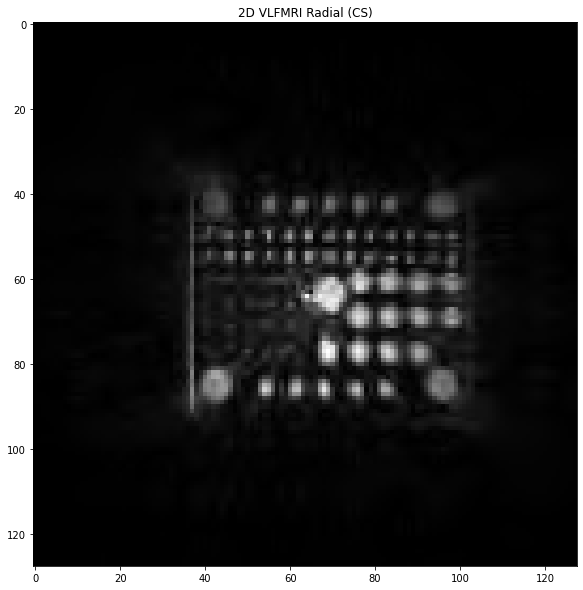

In [73]:
import matplotlib.pyplot as plt
from modopt.math.metrics import ssim, psnr
plt.figure(num=2, figsize = (10,10))
vol = recont_data
plt.imshow(abs(vol), cmap='gray')
plt.title("2D VLFMRI Radial (CS)")